# MoonIndex 

Spectral indexes for the Moon Mineralogical Mapper (M3)

Author:Javier Eduardo Suarez Valencia

Contact: jsuarezvalencia@constructor.university

In [3]:
#Importing libraries
import rioxarray as riox
import numpy as np
import MoonIndex.preparation
import MoonIndex.plotting
import MoonIndex.filtration
import MoonIndex.indexes

# Importing data and preparation

In [4]:
#Defining the paths
path_data='/home/jovyan/work/Index/data' #Path to the data
path_results='/home/jovyan/work/Index/results'#Path to the results
target='M3_Archytas' #Name of the used cube

This M3 cube is already proccesed to level 2, hence its values are reflectance and is map projected (see USGS ISIS3)

In [5]:
#Import data: raster and wavelengths
input_cube=riox.open_rasterio(f'{path_data}/{target}.tif') 
wavelengths_full=np.loadtxt(f'{path_data}/Wavelength_original.txt', delimiter=",")  #This file contains the wavelegnths values of M3, it is neccesary to have it
wavelengths_full=(wavelengths_full/1000).astype(np.float32)

In [6]:
#This function attach the wavelength to the cube, sets the no value data to 0 and deletes the two first malfunctioning bands, and the bands after 2700 nm
def attach_wavelen (cube_alone,wave):
    cube_alone2=cube_alone[0:83,:,:]
    cube_alone2.data[cube_alone2.data < -1000]= 0
    cube_alone2.data[cube_alone2.data > 1000]= 0
    cube_alone2.coords['wavelength'] = ('band', wave)
    cube_wave = cube_alone2.swap_dims({'band':'wavelength'})
    return cube_wave
M3_input_cube=attach_wavelen(input_cube,wavelengths_full)

/home/jovyan/work/Index/MoonIndex/preparation.py:29: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[1].imshow(M3_cubecrop[0,:,:])


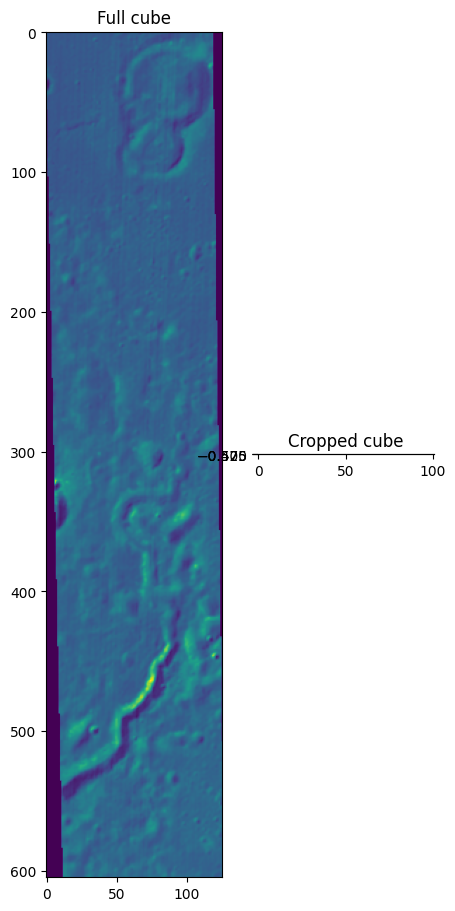

In [8]:
#Croppind the data with coordiantes
#M3_cube=MoonIndex.preparation.crop_cube(M3_input_cube,-152.5,-35,-151.5,-34) #Inputs are the cube and the coordinates to crop, minx, miny, maxx, maxy
#Cropping the data with indexes
M3_cube=MoonIndex.preparation.crop_cube_size(M3_input_cube,25,630,2700,2800)  #Inputs are the cubes and the coordinates of the cropping rectangle (x limits and y limits)

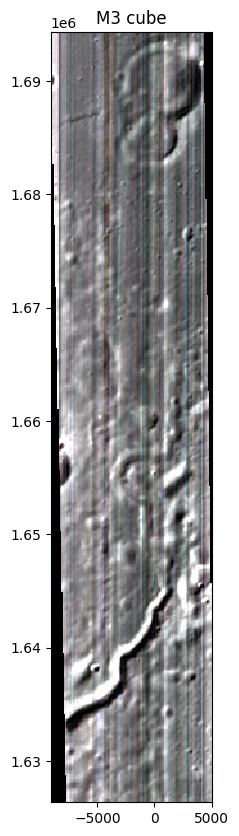

In [9]:
#Viewing the data, arguments are the cube and the size
#M3_cube.rio.to_raster(f'{path_results}/{target}_Clip.tif')
MoonIndex.plotting.cube_plot(M3_input_cube[0:3,:,:],10,'M3 cube')

In [10]:
#Defining the shape of the cube, x=bands, y=vertical, z=horizontal
x,y,z=M3_cube.shape
x,y,z

(83, 0, 101)

# Obtaining all the indexes with one function

The next functions output the final cubes with all the indexes for the two continuum-removal methods. After that, the procces is described in detail and each product is created step by step.

In [11]:
#Obtaining all the indexes in a single cube by the convex hull method
M3_full_CH=MoonIndex.indexes.indexes_total_CH(M3_input_cube,wavelengths_full)
M3_full_CH.rio.to_raster(f'{path_results}/{target}_indexes_CH2.tif')

In [9]:
#Obtaining all the indexes in a single cube by the convex linear-fit method
M3_full_LF=MoonIndex.indexes.indexes_total_LF(M3_cube,wavelengths_full,2,1)
M3_full_LF.rio.to_raster(f'{path_results}/{target}_indexes_LF2.tif')

# Smoothing of the Spectra

M3 data shows vertical stripes that sometimes make it difficult to see the scientific information. Shkuratov et al. (2019) developed a workflow to enhance the quality of the data, which include a fourier and a gaussian filtration. While checking the efect of the fitlers to the indexes, we found that some are better without certain filtrations, so some indexes have diferent inputs.

To check that actual data is not being lost during the filtering, we check first the ratio beetwen the input and ooutput, it should show lunar features if data is being lost. And second, we mapped the pixels that changed more than 2% after the filter, which are the pixel mapped as 0. As seen in both cases, the affected information is related to the verticla stripes and not the spectral data. 

/home/jovyan/work/Index/MoonIndex/plotting.py:66: RuntimeWarning: divide by zero encountered in log
  mshift_mask_mag = 20 * np.log(cv2.magnitude(mfouraster2[:, :, 0], mfouraster2[:, :, 1]))  #For plotting


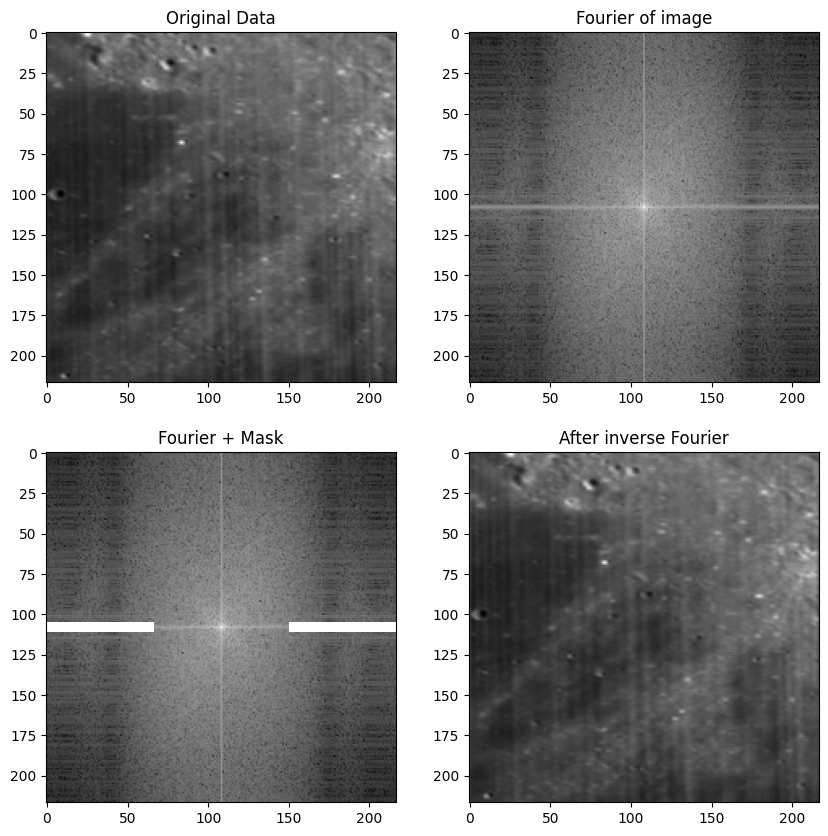

In [11]:
#Doing a fourier filtration, maybe put the filter to 30 percent of the large
M3_fourier=MoonIndex.filtration.fourier_filter(M3_cube,60,2)  #Inputs the cube, and width and altitude of the mask in total percentage

#Plotting to check
MoonIndex.plotting.fourier_plot(M3_cube,5,60,2)  #Inputs the cube, band, and width and altitude of the mask in total percentage

/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


<module 'matplotlib.pyplot' from '/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/matplotlib/pyplot.py'>

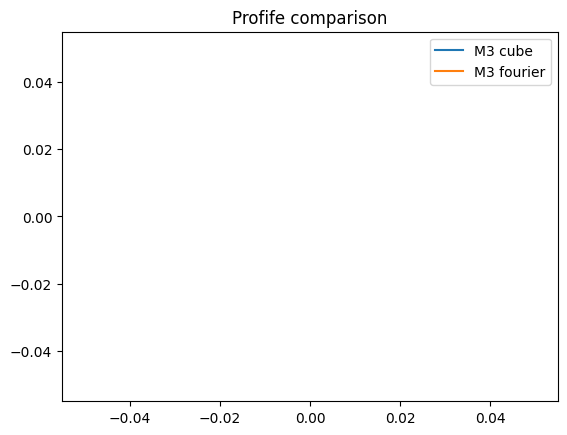

In [12]:
#Comparing a spectral signature before and after the gaussian fitler
MoonIndex.plotting.profiles_comparison(wavelengths_full,M3_cube.data,M3_fourier.data,"M3 cube","M3 fourier", 100,234,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi

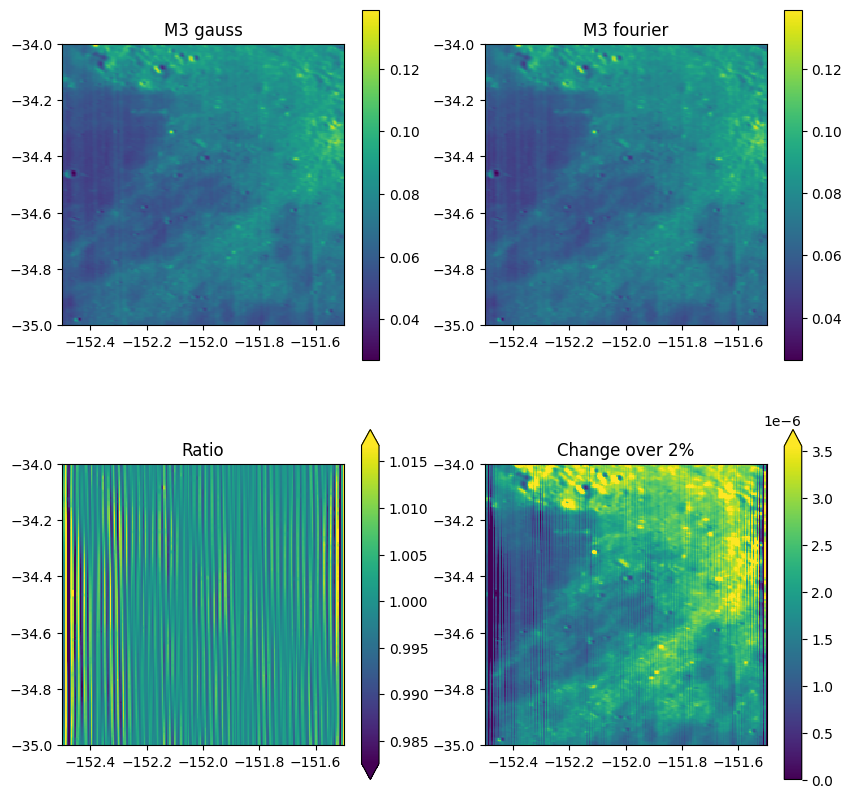

In [13]:
#Plotting the images to compare
MoonIndex.plotting.filter_comparison(M3_cube,M3_fourier,"M3 gauss", "M3 fourier",40) #Inputs are the cubes to compare, their names, and the band

/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


<module 'matplotlib.pyplot' from '/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/matplotlib/pyplot.py'>

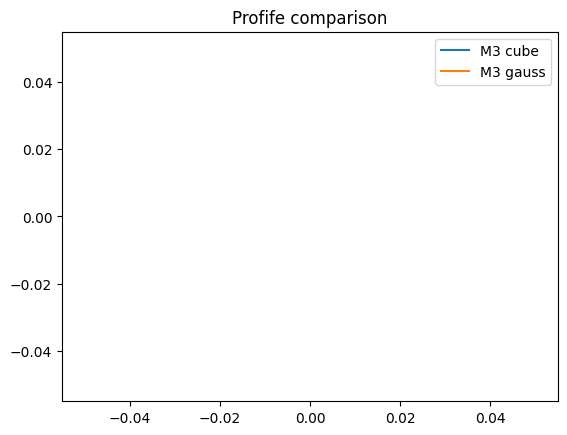

In [14]:
#Doing a gaussian filtration
M3_gauss=MoonIndex.filtration.gauss_filter(M3_fourier,wavelengths_full)  #Inputs are the original cube and wavelengths
M3_gauss.rio.to_raster(f'{path_results}/{target}_Filtered.tif')

#Comparing a spectral signature before and after the gaussian fitler
MoonIndex.plotting.profiles_comparison(wavelengths_full,M3_fourier.data,M3_gauss.data,"M3 cube","M3 gauss",123, 245,3)  #Inputs are the cubes to compare, wavelengths, their names, pixel x, y, and roi

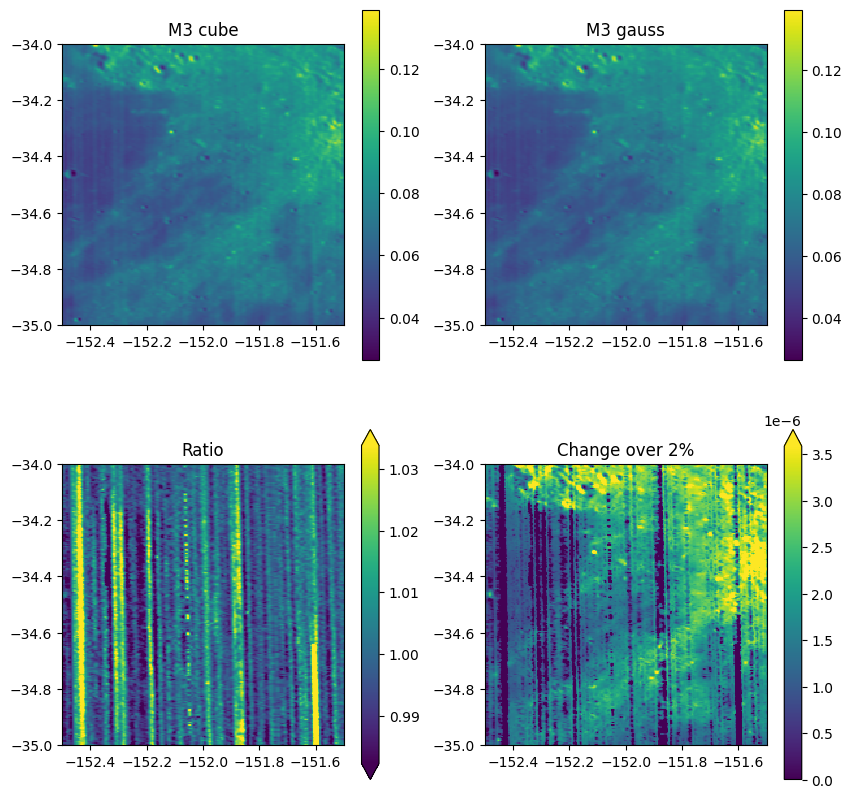

In [15]:
#Plotting the images to compare
MoonIndex.plotting.filter_comparison(M3_fourier,M3_gauss,"M3 cube", "M3 gauss",40) #Inputs are the cubes to compare, their names, and the band

# Continuum removal with the convex hull method

In order to obtain the indexes, it is neccesary to extract the continuum of the spectra to properly locate the absorption centers, shoulders and shapes. There are several methos to do it, but we opted for the convex hull removal method, following Shkuratov et al. (2019), as it is straighforward and correctly derives the shape of the spectrum. A problem of M3 spectra is that the upwards trend make the dificult the convex hull aplication, to solve that we previously created a point with the local maxima between 1000 and 1500 nm, so it could be added to the convex hull and the absorption peak would not be distorded.

In [122]:
#Function to find the midpoint to add to the convexhull
M3_midpoint=MoonIndex.preparation.midpoint(M3_gauss,wavelengths_full,6,0.002)  #Inputs are the filtered cube, the wavelengths, and the distance and prominence of the peaks

In [123]:
#Function to remove the continnum by the convex hull method, it is computed only until 2700 nm
M3_hull = MoonIndex.preparation.convexhull_removal(M3_gauss,wavelengths_full, M3_midpoint)  #Inputs are the filtered cube, wavelengths and the midpoint

<module 'matplotlib.pyplot' from '/home/jovyan/work/.conda/envs/spectral/lib/python3.10/site-packages/matplotlib/pyplot.py'>

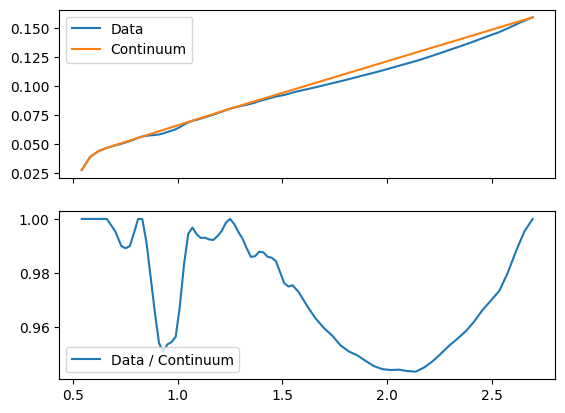

In [124]:
#Convex hull plotting
MoonIndex.plotting.convexhull_plot(M3_gauss.data,wavelengths_full, M3_midpoint.data,20,80) #Inputs are filtered cube, wavelengths, midpoint,x, y and ROI

In [125]:
#Exporting the continumm removed cube
M3_hull_export=M3_hull.copy()
M3_hull_export.data[M3_hull_export.data==0]=np.nan
M3_hull_export.rio.to_raster(f'{path_results}/{target}_conremoved_CH.tif') 

The band minimuum is a key value to create the indexes. This function looks for the minimuum value of the continuum removed cube between 540 nm and the midpoint for the 1000 nm minimuum, and between the midpoint and 2696.73 nm for the 2000 nm minimuum. Then it stores the wavelength of that point.

In [126]:
# Making rasters with the wavelength of minimum reflectance in 1000 um and 2000 um respectively
M3_min1000, M3_min2000=MoonIndex.preparation.find_minimums_ch(M3_hull,M3_midpoint,wavelengths_full)  #Inputs are the convex hull and wavelengths, outputa the two minimums

The other key value to make the indexes are the band shoulders. This function looks in the continuum removed cube for the maximums between 540 nm and the minimum, and between te minimum and the midpoint, for the left and right shoulders of the 1000 nm minimuum respectively. Then between te midpoint and the minimum at 2000 nm, and between the minimum at 2000 nm and 2736.65 nm, for the left and right shoulders of the 2000 nm minimuum respectively.

In [127]:
#Obtaining the shoulders, point of maximum reflectance beetween the minimum
M3_shoulder0, M3_shoulder1, M3_shoulder2, M3_shoulder3=MoonIndex.preparation.find_shoulders_ch(M3_hull,M3_midpoint,M3_min1000,M3_min2000,wavelengths_full)  #Inputs convex hull and wavelengths, outputs the four shoulders

# Indexes - General

These are single band indexes found in the literature, they operate over some bands to highlight the presence of certain minerals.

In [ ]:
#R540, reflectance at 540 nm (Zambon et al., 2020)
M3_R540=MoonIndex.indexes.R540(M3_gauss) #Input filtered cube
M3_R540.rio.to_raster(f'{path_results}/{target}_R540.tif')

#R1580, reflectance at 540 nm (Zambon et al., 2020)
M3_R1580=MoonIndex.indexes.R1580(M3_gauss) #Input filtered cube
M3_R1580.rio.to_raster(f'{path_results}/{target}_R1580.tif')

#Spinel detection index (Moriarty III et al. 2022)
M3_sp=MoonIndex.indexes.spinel(M3_gauss)  #Input filtered cube
M3_sp.rio.to_raster(f'{path_results}/{target}_Sp.tif')

#Olivine detection index  (Corley et al., 2018)
M3_ol=MoonIndex.indexes.olivine(M3_gauss)  #Input filtered cube
M3_ol.rio.to_raster(f'{path_results}/{target}_Ol.tif')

#Chromite detection index (Moriarty III et al. 2022)
M3_cr=MoonIndex.indexes.chromite(M3_gauss)  #Input filtered cube
M3_cr.rio.to_raster(f'{path_results}/{target}_cr.tif')

#FeO detection index  (Corley et al., 2018)
M3_fe=MoonIndex.indexes.iron(M3_gauss)  #Input filtered cube
M3_fe.rio.to_raster(f'{path_results}/{target}_fe.tif')

#Ti detection index  (Corley et al., 2018)
M3_ti=MoonIndex.indexes.titanium(M3_gauss)  #Input filtered cube
M3_ti.rio.to_raster(f'{path_results}/{target}_ti.tif')

#Plot
MoonIndex.plotting.image_plot(M3_ol,10,'M3 olivine index')

These are RGB composites to highlight differences between mineral species.

In [ ]:
#Clementine-like RGB. R: R750 nm/R540 nm, G:,R750 nm/R1000 nm, B:R540nm/R750 nm
M3_clem=MoonIndex.indexes.clementine(M3_gauss) #Inputs filtered cube
M3_clem.rio.to_raster(f'{path_results}/{target}_CLEM.tif')

#RGB for mineral ratios. R: Pyroxene ratio, G: Spinel ratio, B:Anorthosite ratio (Pieters et al. 2014)
M3_spanpx=MoonIndex.indexes.RGB_spanpx(M3_gauss) #Inputs filtered cube
M3_spanpx.rio.to_raster(f'{path_results}/{target}_Spanpx.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_spanpx,10,'M3 Sp-An-Px')

# Indexes - Convex hull

These indexes were colected in the literature, mainly from Zambon et al. (2020), but also from Bretzfelder et al. (2020), Corley et al. (2018), and Horgan et al. (2014).

In [ ]:
#BCI, Band minimum at 1000
M3_BCI_CH=MoonIndex.indexes.band_center(M3_min1000)
M3_BCI_CH.rio.to_raster(f'{path_results}/{target}_BCI_CH.tif')

#BCII, Band minimum at 2000
M3_BCII_CH=MoonIndex.indexes.band_center(M3_min2000)
M3_BCII_CH.rio.to_raster(f'{path_results}/{target}_BCII_CH.tif')

#Plot
MoonIndex.plotting.image_plot(M3_BCII_CH,10,'M3 min 2000')

The band depth is obtained by dividing the reflectance by the value of the continnum at that location, always positive. The spectral slope of 1000 nm is calculated between the 540 nm band and the first shoulder (Zambon et al., 2020). (Zambon et al., 2020). 

In [ ]:
#BDI, band depth at 1000 nm with the convex hull method
M3_BDI_CH=MoonIndex.indexes.band_depth(M3_hull,M3_min1000,wavelengths_full)
M3_BDI_CH.rio.to_raster(f'{path_results}/{target}_BDI_CH.tif')

#BDII, band depth at 2000 nm with the convex hull method
M3_BDII_CH=MoonIndex.indexes.band_depth(M3_hull,M3_min2000,wavelengths_full)
M3_BDII_CH.rio.to_raster(f'{path_results}/{target}_BDII_CH.tif')

#SS1000, Spectral slope between maximun right shoulder and 540nm
M3_SSI_CH=MoonIndex.indexes.SSI(M3_gauss,M3_shoulder1,wavelengths_full) #Inputs are filtered cube, hull and wavelengths
M3_SSI_CH.rio.to_raster(f'{path_results}/{target}_SSI_CH.tif')

#Plot
MoonIndex.plotting.image_plot(M3_BDII_CH,10,'M3 band depth 2000 nm')

These RGBs are composed from the previous indexes (Zambonet al. 2020).

In [ ]:
#RGB1. R: SSI, G: BDI, B: BDII. Better whitout gaussian
M3_RGB1_CH=MoonIndex.indexes.RGB1(M3_gauss,M3_SSI_CH,M3_BDI_CH,M3_BDII_CH) #Inputs filtered cube, SSI, BDI, BDII
M3_RGB1_CH.rio.to_raster(f'{path_results}/{target}_RGB1_CH.tif')

#RGB2. R: SSI, G: R540 nm, B: BCII.
M3_RGB2_CH=MoonIndex.indexes.RGB2(M3_gauss, M3_SSI_CH, M3_R540,M3_BCII_CH)  #Inputs filtered cube, SSI, R540, BCII
M3_RGB2_CH.rio.to_raster(f'{path_results}/{target}_RGB2_CH.tif')

#RGB3. R: SSBI, G: R540 nm, B: BCI.
M3_RGB3_CH=MoonIndex.indexes.RGB3(M3_gauss,M3_SSI_CH, M3_R540,M3_BCI_CH) #Inputs filtered cube, SSI, R540, BCI
M3_RGB3_CH.rio.to_raster(f'{path_results}/{target}_RGB3_CH.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_RGB3_CH,10,'M3 RGB3')

The indexes RGB4 and 5 use parameters focused on the shape of the spectrum, the band area and asymmetry. The first one is calcualted by aproximation using the method of adding rectangles areas, and the second one calculates the area at both sides of the band centers and then asign the diference as a percentage (Horgan et al., 2014).  

In [ ]:
#Band area 1000 nm
M3_BAII_CH=MoonIndex.indexes.BA(M3_hull,wavelengths_full,M3_shoulder0,M3_shoulder1)

#Band area 2000 nm
M3_BAII_CH=MoonIndex.indexes.BA(M3_hull,wavelengths_full,M3_shoulder2,M3_shoulder3)

#Band asymmetry 1000 nm
M3_ASYI_CH=MoonIndex.indexes.ASY(M3_hull,wavelengths_full,M3_shoulder0,M3_shoulder1,M3_min1000)

#Band asymmetry 2000 nm
M3_BAII_CH=MoonIndex.indexes.ASY(M3_hull,wavelengths_full,M3_shoulder2,M3_shoulder3,M3_min2000)

In [ ]:
#RGB4. R:BCI, G: BCII, B:BAI, this index combines the band centers wit the band area at 1000 nm
M3_RGB4_CH=MoonIndex.indexes.RGB4(M3_hull,wavelengths_full,M3_shoulder0,M3_shoulder1,M3_BCI_CH,M3_BCII_CH)  #Inputs are Filtered cube, wavelengths, shoudlers 0 and 1,min 1000 and 2000
M3_RGB4_CH.rio.to_raster(f'{path_results}/{target}_RGB4_CH.tif')

#RGB5. R:ASY, G:BCI, B: BCII, this index combines the band asymmetry at 1000 with the center at 2000 and the band area at 1000
M3_RGB5_CH=MoonIndex.indexes.RGB5(M3_hull,wavelengths_full, M3_shoulder0,M3_shoulder1,M3_BCI_CH,M3_BCII_CH) #Inputs are filtered cube, wavelengths, shoudlers 0 and 1, minimmuns 1000 and 2000, and the band area 9calculated in a prior step)
M3_RGB5_CH.rio.to_raster(f'{path_results}/{target}_RGB5_CH.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_RGB5_CH,10,'M3 RGB5')

These indexes were taken from Besse et al. 2011, usefull for the study of lunar maria

The RGB 8 index use the integrated band depths at 1000 nm and 2000 nm, those is similar to the band depth, but the operation is done at a range of wavelengths (Bretzfelder et al., 2020). The 2000 nm is calculated between 1658.71 nm and 2497.11 nm, and the 1000 nm is calculated between 790.37 nm and 1309.38 nm.    

In [ ]:
#IBDI, integrated band depth at 1000 nm
M3_IBDI_CH=MoonIndex.indexes.IBDI(M3_hull)
M3_IBDI_CH.rio.to_raster(f'{path_results}/{target}_IBDI_CH.tif')

#IBDII, integrated band depth at 1000 nm
M3_IBDII_CH=MoonIndex.indexes.IBDII(M3_hull)
M3_IBDII_CH.rio.to_raster(f'{path_results}/{target}_IBDII_CH.tif')

#RGB6, Band depths at 950, 1050 and 1250
M3_RGB6_CH=MoonIndex.indexes.RGB6(M3_hull)
M3_RGB6_CH.rio.to_raster(f'{path_results}/{target}_RGB6_CH.tif')

#RGB7, BaNd depths at 950, 1050 and 1250
M3_RGB7_CH=MoonIndex.indexes.RGB7(M3_gauss,M3_R1580,M3_IBDI_CH,M3_IBDII_CH)
M3_RGB7_CH.rio.to_raster(f'{path_results}/{target}_RGB7_CH.tif')

#Plotting
MoonIndex.plotting.cube_plot(M3_RGB6_CH,10,'M3 RGB6 - convex hull')

In [ ]:
#NIR. R: band depth (BD) 1900, integrated band depth(IBD) 2000, integrated band depth (IBD) 1000
M3_RGB8_CH=MoonIndex.indexes.NIR(M3_gauss,M3_hull)
M3_RGB8_CH.rio.to_raster(f'{path_results}/{target}_RGB8_CH.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_RB8_CH,10,'M3 RGB 8')

# Linear fit continuum removal method

The lienar-fit removal method does not iterate over the full spectrum, instad it makes a 2 order fit in the 1000 nm region and a linear fit in the 2000 nm region. The definition of the fit positions is derived from literature (Zambon et al., 2020), the 1000 nm fit is done between then ranges 580-770 nm and 1400-1469 nm, and the fit in 2000 nm between the last point and 2656 nm. he minimums and shoudlers are ten calculated using this continnum-removed spectrum. 

The main disadvantage of tihs method is the arbitrary selection of the interpolation points. 

In [16]:
#Continuum removal with the linear fit method
M3_lf=MoonIndex.preparation.continuum_removal_lf(M3_gauss,wavelengths_full,2,1) #Inptus are the filtered cube, wavelegnths, and the order of the polynomial fit for the 1000 nm and 2000 nm band
M3_lf.rio.to_raster(f'{path_results}/{target}_conremoved_LF.tif')

In [ ]:
#Plotting of the contunnum removed spectrum
MoonIndex.plotting.linearfit_plot(M3_gauss,M3_lf,wavelengths_full,20,80)

In general we can see that the convexhull understimates the band depth around 1000 mn, probably due to the use of a second order in the fit method, appart from that, the position of the minimmuns are consistent.

In [ ]:
#Comapring the continnum removal between the two methoda
MoonIndex.plotting.profiles_comparison(wavelengths_full,M3_hull,M3_lf, "Convex hull", "Linear fit",20,80,3)

In [ ]:
#Minimuums calculation with the linear fit method
M3_min1000lf,M3_min2000lf=MoonIndex.preparation.find_minimuumslf(M3_lf,wavelengths_full)

In [ ]:
#Maximums calculation with the linear fit method
M3_shoulder0lf,M3_shoulder1lf,M3_shoulder2lf=MoonIndex.preparation.find_shoulders_lf(M3_lf,M3_min1000lf,M3_min2000lf,wavelengths_full)

# Indexes - Linear fit

In [ ]:
#BCI, Band minimum at 1000 linear-fit
M3_BCI_LF=MoonIndex.indexes.band_center(M3_min1000lf)
M3_BCI_LF.rio.to_raster(f'{path_results}/{target}_BCI_LF.tif')

#BCII, Band minimum at 2000 linear-fit method
M3_BCII_LF=MoonIndex.indexes.band_center(M3_min2000lf)
M3_BCII_LF.rio.to_raster(f'{path_results}/{target}_BCII_LF.tif')

#Plot
MoonIndex.plotting.image_plot(M3_BCII_LF,10,'M3 min 2000 - linear fit')

In [ ]:
#BDI, band depth at 1000 nm with the linear fit method
M3_BDI_LF=MoonIndex.indexes.band_depth(M3_lf,M3_min1000lf,wavelengths_full)
M3_BDI_LF.rio.to_raster(f'{path_results}/{target}_BDI_LF.tif')

#BDII, band depth at 1000 nm with the linear fit method
M3_BDII_LF=MoonIndex.indexes.band_depth(M3_lf,M3_min2000lf,wavelengths_full)
M3_BDII_LF.rio.to_raster(f'{path_results}/{target}_BDII_LF.tif')

#SS1000, Spectral slope between maximun right shoulder and 540nm linear fit method
M3_SSI_LF=MoonIndex.indexes.SSI(M3_gauss,M3_shoulder1lf,wavelengths_full) #Inputs are filtered cube, hull and wavelengths
M3_SSI_LF.rio.to_raster(f'{path_results}/{target}_SSI_LF.tif')

#Plot
MoonIndex.plotting.image_plot(M3_BDII_LF,10,'M3 band depth 2000 nm - linear fit')

In [ ]:
#RGBs (Zambon et al., 2020) with the linear fit method
#RGB1. R: SSI, G: BDI, B: BDII. Better whitout gaussian
M3_RGB1_LF=MoonIndex.indexes.RGB1(M3_gauss,M3_SSI_LF,M3_BDI_LF,M3_BDII_LF) #Inputs filtered cube, SSI, BDI, BDII
M3_RGB1_LF.rio.to_raster(f'{path_results}/{target}_RGB1_LF.tif')

#RGB2. R: SSI, G: R540 nm, B: BCII.
M3_RGB2_LF=MoonIndex.indexes.RGB2(M3_gauss, M3_SSI_LF, M3_R540, M3_min2000lf)  #Inputs filtered cube, SSI, R540, BCII
M3_RGB2_LF.rio.to_raster(f'{path_results}/{target}_RGB2_LF.tif')

#RGB3. R: SSBI, G: R540 nm, B: BCI.
M3_RGB3_LF=MoonIndex.indexes.RGB3(M3_gauss,M3_SSI_LF, M3_R540,M3_min1000lf) #Inputs filtered cube, SSI, R540, BCI
M3_RGB3_LF.rio.to_raster(f'{path_results}/{target}_RGB3_LF.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_RGB3_LF,10,'M3 RGB3 - linear fit')

In [ ]:
#Band area 1000 nm
M3_BAII_LF=MoonIndex.indexes.BA(M3_lf,wavelengths_full,M3_shoulder0lf,M3_shoulder1lf)

#Band area 2000 nm
M3_BAII_LF=MoonIndex.indexes.BA(M3_lf,wavelengths_full,M3_shoulder1lf,M3_shoulder2lf)

#Band asymmetry 1000 nm
M3_ASYI_LF=MoonIndex.indexes.ASY(M3_lf,wavelengths_full,M3_shoulder0lf,M3_shoulder1lf,M3_min1000lf)

#Band asymmetry 2000 nm
M3_ASYII_LF=MoonIndex.indexes.ASY(M3_lf,wavelengths_full,M3_shoulder1lf,M3_shoulder2lf,M3_min2000lf)

In [ ]:
#RGBs Horgan with the linear fit method
#RGB4. R:BCI, G: BCII, B:BAI, this index combines the band centers wit the band area at 1000 nm
M3_RGB4_LF=MoonIndex.indexes.RGB4(M3_lf,wavelengths_full,M3_shoulder0lf,M3_shoulder1lf,M3_min1000lf,M3_min2000lf)  #Inputs are Filtered cube, wavelengths, shoudlers 0 and 1,min 1000 and 2000
M3_RGB4_LF.rio.to_raster(f'{path_results}/{target}_RGB4_LF.tif')

#RGB5. R:ASY, G:BCI, B: BCII, this index combines the band asymmetry at 1000 with the center at 2000 and the band area at 1000
M3_RGB5_LF=MoonIndex.indexes.RGB5(M3_lf,wavelengths_full, M3_shoulder0lf,M3_shoulder1lf,M3_min1000lf,M3_min2000lf) #Inputs are filtered cube, wavelengths, shoudlers 0 and 1, minimmuns 1000 and 2000, and the band area 9calculated in a prior step)
M3_RGB5_LF.rio.to_raster(f'{path_results}/{target}_RGB5_LF.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_RGB5_LF,10,'M3 RGB5 - linear fit')

In [ ]:
#IBDI, integrated band depth at 1000 nm
M3_IBDI_LF=MoonIndex.indexes.IBDI(M3_lf)
M3_IBDI_LF.rio.to_raster(f'{path_results}/{target}_IBDI_LF.tif')

#IBDII, integrated band depth at 1000 nm
M3_IBDII_LF=MoonIndex.indexes.IBDII(M3_lf)
M3_IBDII_LF.rio.to_raster(f'{path_results}/{target}_IBDII_LF.tif')

#RGB6, Band depths at 950, 1050 and 1250
M3_RGB6_LF=MoonIndex.indexes.RGB6(M3_lf)
M3_RGB6_LF.rio.to_raster(f'{path_results}/{target}_RGB6_LF.tif')

#RGB7, Band depths at 950, 1050 and 1250
M3_RGB7_LF=MoonIndex.indexes.RGB7(M3_gauss,M3_R1580,M3_IBDI_LF,M3_IBDII_LF)
M3_RGB7_LF.rio.to_raster(f'{path_results}/{target}_RGB7_LF.tif')
                                  
#Plot
MoonIndex.plotting.cube_plot(M3_RGB6_LF,10,'M3 NIR - linear fit')

In [ ]:
#RGB8. R: band depth (BD) 1900, integrated band depth(IBD) 2000, integrated band depth (IBD) 1000, lienar fit method
M3_RGB8_LF=MoonIndex.indexes.NIR(M3_gauss,M3_lf)
M3_RGB8_LF.rio.to_raster(f'{path_results}/{target}_RGB8_LF.tif')

#Plot
MoonIndex.plotting.cube_plot(M3_NIR_LF,10,'M3 RGB 8 - linear fit')

# References

Bretzfelder, J. M., Klima, R. L., Greenhagen, B. T., Buczkowski, D. L., Petro, N. E., & Day, M. (2020). Identification of Potential Mantle Rocks Around the Lunar Imbrium Basin. Geophysical Research Letters, 47(22). https://doi.org/10.1029/2020GL090334

Clenet, H. (2009). Télédétection hyperspectrale: Minéralogie et pétrologie, Application au volcan Syrtis Major (Mars) et à l’ophiolite d’Oman. Université de Toulouse.

Corley, L. M., McGovern, P. J., Kramer, G. Y., Lemelin, M., Trang, D., Gillis-Davis, J. J., Taylor, G. J., Powell, K. E., Kiefer, W. S., Wieczorek, M., & Zuber, M. T. (2018). Olivine-bearing lithologies on the Moon: Constraints on origins and transport mechanisms from M3 spectroscopy, radiative transfer modeling, and GRAIL crustal thickness. Icarus, 300, 287-304. https://doi.org/10.1016/j.icarus.2017.09.012

Horgan, B. H. N., Cloutis, E. A., Mann, P., & Bell, J. F. (2014). Near-infrared spectra of ferrous mineral mixtures and methods for their identification in planetary surface spectra. Icarus, 234, 132-154. https://doi.org/10.1016/j.icarus.2014.02.031

Shkuratov, Yu., Surkov, Ye., Ivanov, M., Korokhin, V., Kaydash, V., Videen, G., Pieters, C., & Stankevich, D. (2019). Improved Chandrayaan-1 M3 data: A northwest portion of the Aristarchus Plateau and contiguous maria. Icarus, 321, 34-49. https://doi.org/10.1016/j.icarus.2018.11.002

Zambon, F., Carli, C., Altieri, F., Luzzi, E., Combe, J.-P., Ferrari, S., Tognon, G., & Massironi, M. (2020). Spectral Index and RGB maps—Beethoven, Rembrandt basins on Mercury, Apollo basin and Leibnitz and Von Karman craters regions on the Moon (p. 57).


## Work in progress